In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("omkarmanohardalvi/lungs-disease-dataset-4-types")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/lungs-disease-dataset-4-types


In [ ]:
import os

base_path = '/kaggle/input/lungs-disease-dataset-4-types'

print(os.listdir(base_path))


['Lung Disease Dataset']


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout
from tensorflow.keras.applications import DenseNet121, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 1. Data Augmentation
train_gen = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.5],
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1/255
)
val_gen = ImageDataGenerator(rescale=1/255)
test_gen = ImageDataGenerator(rescale=1/255)

# 2. Data Loading
train_data = train_gen.flow_from_directory(
    os.path.join(base_path, 'Lung Disease Dataset', 'train'),
    target_size=(128, 128),
    color_mode="rgb",
    batch_size=128,
    shuffle=True
)

val_data = val_gen.flow_from_directory(
    os.path.join(base_path, 'Lung Disease Dataset', 'val'),
    target_size=(128, 128),
    color_mode="rgb",
    batch_size=128,
    shuffle=True
)

test_data = test_gen.flow_from_directory(
    os.path.join(base_path, 'Lung Disease Dataset', 'test'),
    target_size=(128, 128),
    color_mode="rgb",
    batch_size=128,
    shuffle=False
)

# 3. Model Building (Hybrid DenseNet + ResNet)

# 3. Model Building (Hybrid DenseNet + ResNet)

input_layer = Input(shape=(128, 128, 3))

# Load DenseNet
dense_net = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
dense_out = dense_net(input_layer)
dense_out = GlobalAveragePooling2D()(dense_out)

# Load ResNet
res_net = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
res_out = res_net(input_layer)
res_out = GlobalAveragePooling2D()(res_out)

# Concatenate outputs
merged = Concatenate()([dense_out, res_out])

# Add dense layers
x = Dense(512, activation='relu')(merged)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
output_layer = Dense(5, activation='softmax')(x)

# Final model
model = Model(inputs=input_layer, outputs=output_layer)

model.summary()


# 4. Compile
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# 5. Early Stopping
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)

# 6. Train
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=40,
    callbacks=[early_stopping]
)



Found 6054 images belonging to 5 classes.
Found 2016 images belonging to 5 classes.
Found 2025 images belonging to 5 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ densenet121         │ (None, 4, 4,      │  7,037,504 │ input_layer[0][0] │
│ (Functional)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 4, 4,      │ 23,587,712 │ input_layer[0][0] │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1024)      │          0 │ densenet121[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3072)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  1,573,376 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 5)         │      1,285 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 32,331,205 (123.33 MB)

 Trainable params: 32,194,437 (122.81 MB)

 Non-trainable params: 136,768 (534.25 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 489s 6s/step - accuracy: 0.5057 - loss: 1.2795 - val_accuracy: 0.4082 - val_loss: 1.4297
Epoch 2/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.8008 - loss: 0.4899 - val_accuracy: 0.6200 - val_loss: 1.0186
Epoch 3/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.8237 - loss: 0.4270 - val_accuracy: 0.2014 - val_loss: 9.9627
Epoch 4/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.8378 - loss: 0.3842 - val_accuracy: 0.2014 - val_loss: 6.3847
Epoch 5/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.8440 - loss: 0.3530 - val_accuracy: 0.2029 - val_loss: 10.1151
Epoch 6/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.8598 - loss: 0.3559 - val_accuracy: 0.2604 - val_loss: 2.7457
Epoch 7/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.8626 - loss: 0.3223 - val_accuracy: 0.4792 - val_loss: 1.2129
Epoch 8/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.8679 - loss: 0.3134 - val_accuracy: 0.4266 - 

In [ ]:
model.save("hybrid_model.keras")


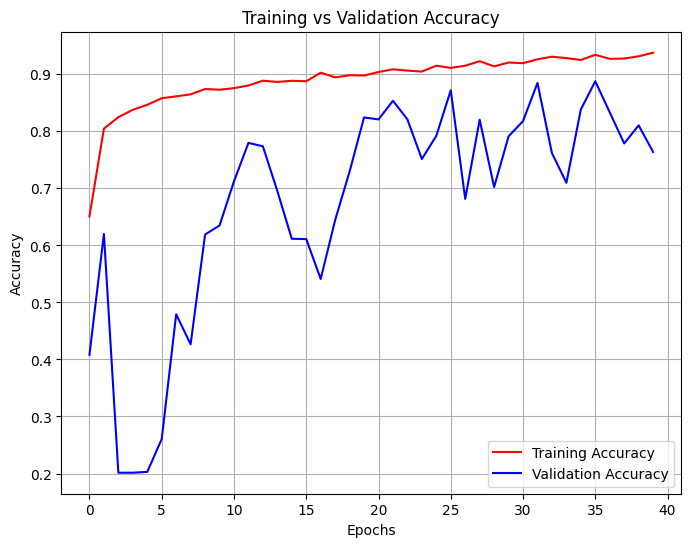

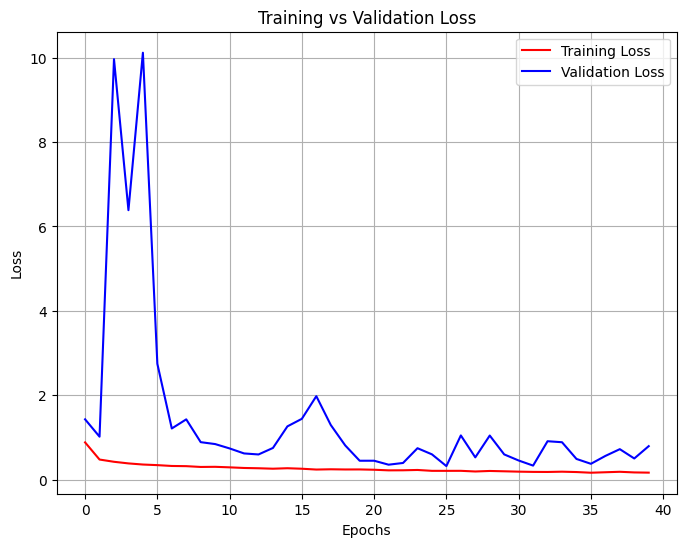

In [ ]:
# Accuracy graph
plt.figure(figsize=(8, 6))
plt.plot(history.history["accuracy"], label="Training Accuracy", color='r')
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", color='b')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss graph
plt.figure(figsize=(8, 6))
plt.plot(history.history["loss"], label="Training Loss", color='r')
plt.plot(history.history["val_loss"], label="Validation Loss", color='b')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
Predicted Class: Tuberculosis


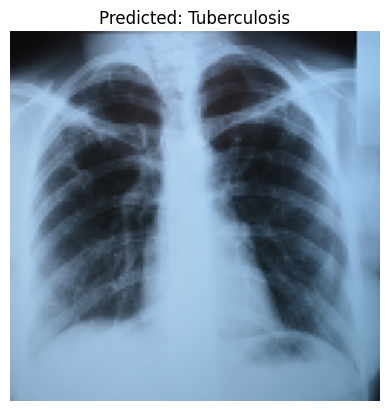

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# 1. Load your image
img_path = '/content/Tb.jpg'  # 🔥 Change to your test image path
img = image.load_img(img_path, target_size=(128, 128), color_mode="rgb")

# 2. Convert to array
img_array = image.img_to_array(img)

# 3. Normalize
img_array = img_array / 255.0

# 4. Expand dimensions (batch format)
img_array = np.expand_dims(img_array, axis=0)

# 5. Predict
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)

# 6. Map the prediction back to class name
class_labels = list(test_data.class_indices.keys())
print(f"Predicted Class: {class_labels[predicted_class[0]]}")

# 7. Visualize the image
plt.imshow(img_array[0])
plt.title(f"Predicted: {class_labels[predicted_class[0]]}")
plt.axis('off')
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.8852 - loss: 0.3765
✅ Test Loss: 0.4242
✅ Test Accuracy: 0.8765
16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step


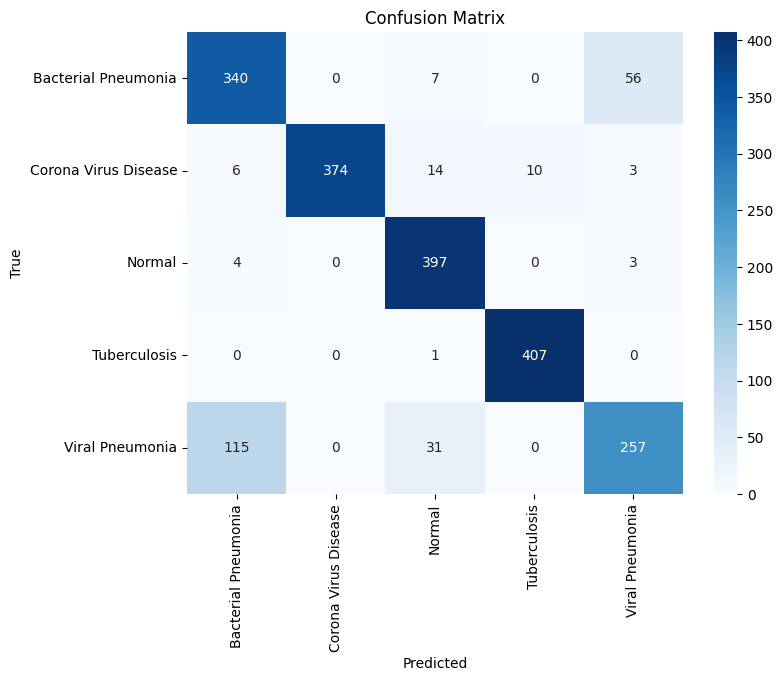

📊 Classification Report:
                       precision    recall  f1-score   support

 Bacterial Pneumonia       0.73      0.84      0.78       403
Corona Virus Disease       1.00      0.92      0.96       407
              Normal       0.88      0.98      0.93       404
        Tuberculosis       0.98      1.00      0.99       408
     Viral Pneumonia       0.81      0.64      0.71       403

            accuracy                           0.88      2025
           macro avg       0.88      0.88      0.87      2025
        weighted avg       0.88      0.88      0.87      2025



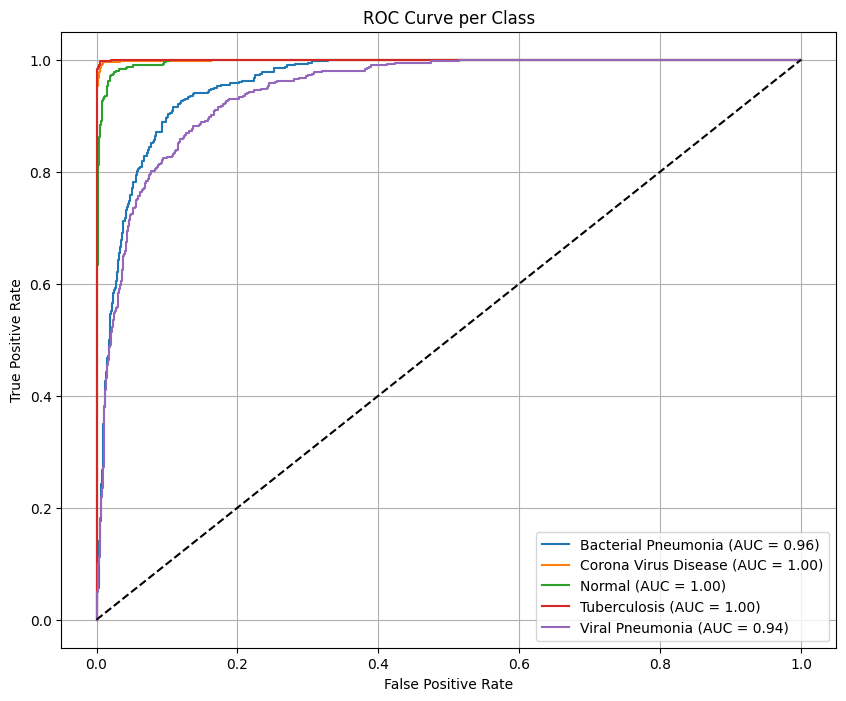

📁 Confusion matrix saved as 'confusion_matrix.csv'
📁 Classification report saved as 'classification_report.txt'


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model

# 2. Evaluate on test data
loss, accuracy = model.evaluate(test_data)
print(f"✅ Test Loss: {loss:.4f}")
print(f"✅ Test Accuracy: {accuracy:.4f}")

# 3. Predict on test data
y_pred_probs = model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_data.classes
class_labels = list(test_data.class_indices.keys())

# 4. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 5. Classification Report (Precision, Recall, F1)
report = classification_report(y_true, y_pred, target_names=class_labels)
print("📊 Classification Report:\n", report)

# 6. ROC Curve (One-vs-Rest for multi-class)
y_true_bin = label_binarize(y_true, classes=list(range(len(class_labels))))
y_pred_bin = y_pred_probs

plt.figure(figsize=(10, 8))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve per Class")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 7. (Optional) Save confusion matrix and report to file
conf_matrix_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
conf_matrix_df.to_csv("confusion_matrix.csv")

with open("classification_report.txt", "w") as f:
    f.write(report)

print("📁 Confusion matrix saved as 'confusion_matrix.csv'")
print("📁 Classification report saved as 'classification_report.txt'")
